In [1]:
# %pip install -r /home/huuquangdang/huu.quang.dang/thesis/deepfake/deepfake_backend/libs/model/CelebV2/requirements.txt

# # Step 1: Uninstall incompatible NumPy version
# %pip uninstall numpy -y
# # Step 2: Install compatible NumPy version (< 2.0.0)
# %pip install "numpy>=1.21.0,<2.0.0"
# # Step 3: Verify NumPy version
# import numpy as np
# print(f"✅ NumPy version: {np.__version__}")
# print(f"Expected: < 2.0.0 (you should see 1.x.x)")

In [2]:
# Built-in
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, GlobalAveragePooling2D, LSTM, Dense, Dropout
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

2025-10-18 22:36:28.814417: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-18 22:36:28.858731: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-18 22:36:29.219094: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-18 22:36:29.219142: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-18 22:36:29.220477: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [3]:
# Define the path to the dataset
base_path = '/home/huuquangdang/huu.quang.dang/thesis/Dataset/celeb_df_crop'
categories = ['fake', 'real']

# Initialize a list to hold data
data = []

# Process each category
for category in categories:
    category_path = os.path.join(base_path, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.jpg'):
            try:
                id_part, frame_part = filename.split('_frame_')
                id_ = id_part.split('_')[0]
                frame = frame_part.split('.')[0]
                data.append({
                    'filename': filename,
                    'path': os.path.join(category_path, filename),
                    'id': int(id_),
                    'frame': int(frame),
                    'label': category
                })
            except ValueError:
                continue

# Convert the data to a DataFrame
df = pd.DataFrame(data)

In [4]:
# Đảm bảo đã có df_cropped.csv chứa đường dẫn ảnh đã crop
df['label_id'] = df['label'].map({'fake': 0, 'real': 1})
df


,filename,path,id,frame,label,label_id
0,264_id37_0009_frame_0001.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,264,1,fake,0
1,271_id38_0006_frame_0014.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,271,14,fake,0
2,015_id10_0006_frame_0027.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,15,27,fake,0
3,392_id4_0007_frame_0028.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,392,28,fake,0
4,029_id11_0010_frame_0004.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,29,4,fake,0
...,...,...,...,...,...,...
32367,475_id58_0004_frame_0012.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,475,12,real,1
32368,014_id10_0005_frame_0012.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,14,12,real,1
32369,365_id48_0000_frame_0023.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,365,23,real,1
32370,091_id20_0000_frame_0026.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,91,26,real,1


In [5]:
df['video_key'] = df['id'].astype(str) + "_" + df['label']

from collections import defaultdict

video_dict = defaultdict(list)
labels = {}

for _, row in df.iterrows():
    key = row['video_key']
    video_dict[key].append(row['path'])
    labels[key] = row['label_id']


In [6]:
# !pip install opencv-python

In [7]:
# Load pre-extracted CSV features for feature fusion
print("📂 Loading pre-extracted OpenFace features from CSV files...")
csv_fake_path = '/home/huuquangdang/huu.quang.dang/thesis/deepfake/deepfake_backend/libs/tools/fake/op_vectors_fake_v1.csv'
csv_real_path = '/home/huuquangdang/huu.quang.dang/thesis/deepfake/deepfake_backend/libs/tools/real/op_vectors_real_v1.csv'

df_fake_features = pd.read_csv(csv_fake_path, header=None)
df_real_features = pd.read_csv(csv_real_path, header=None)

# Combine both dataframes
df_all_features = pd.concat([df_fake_features, df_real_features], ignore_index=True)
df_all_features.columns = ['filename'] + [f'feat_{i}' for i in range(df_all_features.shape[1] - 1)]

# Create a dictionary for fast lookup: filename -> features
openface_features = {}
for _, row in df_all_features.iterrows():
    filename = row['filename']
    features = row.iloc[1:].values.astype('float32')
    openface_features[filename] = features

csv_feature_dim = len(features)
print(f"✅ Loaded {len(openface_features)} feature vectors")
print(f"✅ Each vector has {csv_feature_dim} dimensions")
print(f"✅ Feature dictionary ready for 1-to-1 frame mapping")

📂 Loading pre-extracted OpenFace features from CSV files...
✅ Loaded 16223 feature vectors
✅ Each vector has 674 dimensions
✅ Feature dictionary ready for 1-to-1 frame mapping


# 🔬 Model: TCN (Temporal Conv Net) + Residual Blocks + KAN

This cell implements **TCN (dilated 1D CNN) with Residual Blocks** for sequence modeling, while maintaining:

- ✅ Same function names (`VideoSequence`, `build_model`, `hmm_postprocess`)

- ✅ Same 1-to-1 feature fusion (MobileNet + CSV)

- ✅ Same normalization strategy

- ✅ Enhanced with TCN and Residual Blocks

In [8]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (
    Input, TimeDistributed, Dropout, Dense, GlobalAveragePooling2D, 
    Concatenate, BatchNormalization, Conv1D, Add, Activation, LayerNormalization, GlobalAveragePooling1D
    )
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from hmmlearn.hmm import GaussianHMM
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler

# Configuration (same as before)
video_keys = list(video_dict.keys())
video_labels = [labels[k] for k in video_keys]

img_size = (224, 224)
batch_size = 32
epochs = 50
n_splits = 5
sequence_len = 10
results = []
all_histories = []

# Normalize CSV features (same normalization strategy)
print("🔧 Computing CSV feature statistics for normalization...")
all_csv_features = []
for key in video_keys:
    frames = video_dict[key][:sequence_len]
    for path in frames:
        filename = os.path.basename(path)
        if filename in openface_features:
            all_csv_features.append(openface_features[filename])

csv_scaler = StandardScaler()
csv_scaler.fit(all_csv_features)
print(f"✅ CSV feature normalization fitted on {len(all_csv_features)} samples")

# Data generator (SAME NAME, same functionality)
class VideoSequence(tf.keras.utils.Sequence):
    def __init__(self, video_keys, video_dict, labels, batch_size, img_size, sequence_len=10, augment=False):
        self.video_keys = video_keys
        self.video_dict = video_dict
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.sequence_len = sequence_len
        self.augment = augment
        self.datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15 if augment else 0,
            zoom_range=0.1 if augment else 0,
            horizontal_flip=augment
        )

    def __len__(self):
        return int(np.ceil(len(self.video_keys) / self.batch_size))

    def __getitem__(self, idx):
        batch_keys = self.video_keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X_img, batch_X_csv, batch_y = [], [], []

        for key in batch_keys:
            frames = self.video_dict[key][:self.sequence_len]
            imgs = []
            csv_feats = []
            
            for path in frames:
                # Load and process image
                img = cv2.imread(path)
                img = cv2.resize(img, self.img_size)
                img = self.datagen.random_transform(img) if self.augment else img
                img = img.astype('float32') / 255.0
                imgs.append(img)
                
                # Load CSV features and normalize (1-to-1 mapping)
                filename = os.path.basename(path)
                if filename in openface_features:
                    csv_feat = openface_features[filename]
                    csv_feat = csv_scaler.transform([csv_feat])[0]
                else:
                    csv_feat = np.zeros(csv_feature_dim, dtype='float32')
                csv_feats.append(csv_feat)
            
            # Pad sequences if needed
            while len(imgs) < self.sequence_len:
                imgs.append(np.zeros((*self.img_size, 3), dtype='float32'))
                csv_feats.append(np.zeros(csv_feature_dim, dtype='float32'))
            
            batch_X_img.append(imgs)
            batch_X_csv.append(csv_feats)
            batch_y.append(self.labels[key])

        return [np.array(batch_X_img), np.array(batch_X_csv)], np.array(batch_y)

# TCN Residual Block
def tcn_residual_block(x, filters, kernel_size, dilation_rate, block_num):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, name=f'tcn_conv_{block_num}_1')(x)
    x = LayerNormalization(name=f'tcn_ln_{block_num}_1')(x)
    x = Activation('relu', name=f'tcn_relu_{block_num}_1')(x)
    x = Dropout(0.2, name=f'tcn_dropout_{block_num}_1')(x)
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, name=f'tcn_conv_{block_num}_2')(x)
    x = LayerNormalization(name=f'tcn_ln_{block_num}_2')(x)
    x = Activation('relu', name=f'tcn_relu_{block_num}_2')(x)
    x = Dropout(0.2, name=f'tcn_dropout_{block_num}_2')(x)
    # Residual connection
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding='same', name=f'tcn_shortcut_{block_num}')(shortcut)
    x = Add(name=f'tcn_add_{block_num}')([x, shortcut])
    x = Activation('relu', name=f'tcn_out_relu_{block_num}')(x)
    return x

# TCN + Residual Blocks Model (NO KAN)
def build_model(sequence_len, img_size, csv_dim=674):
    # MobileNet branch
    base_cnn = MobileNetV2(input_shape=(*img_size, 3), include_top=False, weights='imagenet')
    base_cnn.trainable = True
    for layer in base_cnn.layers[:-20]:
        layer.trainable = False
    
    cnn_out = GlobalAveragePooling2D()(base_cnn.output)
    cnn_model = Model(inputs=base_cnn.input, outputs=cnn_out)
    
    # Image sequence input
    input_seq_img = Input(shape=(sequence_len, *img_size, 3), name='image_input')
    x_img = TimeDistributed(cnn_model)(input_seq_img)
    
    # CSV features input
    input_seq_csv = Input(shape=(sequence_len, csv_dim), name='csv_input')
    
    # BatchNormalization before fusion
    x_img = BatchNormalization(name='bn_mobilenet')(x_img)
    x_csv = BatchNormalization(name='bn_csv')(input_seq_csv)
    
    # Concatenate features (1-to-1 fusion)
    x_combined = Concatenate(axis=-1, name='feature_fusion')([x_img, x_csv])
    
    # TCN blocks (dilated 1D CNN with residuals)
    x = x_combined
    for i, (filters, kernel_size, dilation_rate) in enumerate([(128, 3, 1), (128, 3, 2), (128, 3, 4), (128, 3, 8)]):
        x = tcn_residual_block(x, filters, kernel_size, dilation_rate, i+1)
    
    # Global average pooling over time dimension to get fixed-size output
    x = GlobalAveragePooling1D(name='global_avg_pool')(x)
    x = Dropout(0.2, name='dropout_tcn')(x)
    
    # Classification layers (NO KAN)
    x = Dense(64, activation='relu', name='dense_1')(x)
    x = Dropout(0.2, name='dropout_3')(x)
    x = Dense(32, activation='relu', name='dense_2')(x)
    x = Dropout(0.2, name='dropout_4')(x)
    
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=[input_seq_img, input_seq_csv], outputs=output, name='TCN_Residual')
    return model

# HMM post-processing (SAME NAME, unchanged)
def hmm_postprocess(pred_probs, y_true, n_states=2):
    pred_probs = pred_probs.reshape(-1, 1)
    hmm = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)
    hmm.fit(pred_probs)
    hidden_states = hmm.predict(pred_probs)

    mapping = {}
    for state in np.unique(hidden_states):
        indices = [i for i in range(len(hidden_states)) if hidden_states[i] == state]
        state_labels = [y_true[i] for i in indices]
        if len(state_labels) > 0:
            mapped_label = mode(state_labels, keepdims=True).mode[0]
        else:
            mapped_label = 0
        mapping[state] = mapped_label

    hmm_labels = np.array([mapping[s] for s in hidden_states])
    return hmm_labels

# Training K-Fold
print("\n🚀 Starting TCN + Residual Blocks Training (NO KAN):")
print("   ✅ TCN (dilated 1D CNN, residual blocks)")
print("   ✅ Normalized CSV features (1-to-1 mapping)")
print("   ✅ MobileNet (last 20 layers trainable)")
print("   ✅ HMM post-processing\n")

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (trainval_idx, test_idx) in enumerate(skf.split(video_keys, video_labels), 1):
    print(f"\n{'='*60}")
    print(f"📊 Fold {fold}/{n_splits} - TCN_Residual")
    print(f"{'='*60}")

    trainval_keys = [video_keys[i] for i in trainval_idx]
    test_keys = [video_keys[i] for i in test_idx]

    y_trainval = [labels[k] for k in trainval_keys]
    train_keys, val_keys = train_test_split(trainval_keys, test_size=0.1, stratify=y_trainval, random_state=fold)

    train_gen = VideoSequence(train_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=True)
    val_gen = VideoSequence(val_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)
    test_gen = VideoSequence(test_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)

    model = build_model(sequence_len, img_size, csv_feature_dim)
    model.compile(optimizer=Adamax(3e-4), loss='binary_crossentropy', metrics=['accuracy'])
    
    print(f"\n📈 Model Architecture:")
    print(f"   - Model: TCN + Residual Blocks (NO KAN)")
    print(f"   - Total params: {model.count_params():,}")
    trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
    print(f"   - Trainable params: {trainable_params:,}")
    print(f"   - TCN: 4 blocks, dilations 1/2/4/8")
    print(f"   - Learning rate: 3e-4")

    model_path = f"best_model_fold{fold}_tcn_res.h5"
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs,
                        callbacks=[checkpoint, earlystop, reduce_lr], verbose=1)
    all_histories.append(history.history)

    model.load_weights(model_path)

    y_true = [labels[k] for k in test_keys]
    y_pred_prob = model.predict(test_gen).ravel()
    y_hmm_pred = hmm_postprocess(y_pred_prob, y_true)

    results.append({
        'fold': fold,
        'accuracy': accuracy_score(y_true, y_hmm_pred),
        'precision': precision_score(y_true, y_hmm_pred),
        'recall': recall_score(y_true, y_hmm_pred),
        'f1': f1_score(y_true, y_hmm_pred),
        'auc': roc_auc_score(y_true, y_pred_prob)
    })
    
    print(f"\n✅ Fold {fold} Results (TCN_Residual):")
    print(f"   Accuracy:  {results[-1]['accuracy']:.4f}")
    print(f"   Precision: {results[-1]['precision']:.4f}")
    print(f"   Recall:    {results[-1]['recall']:.4f}")
    print(f"   F1 Score:  {results[-1]['f1']:.4f}")
    print(f"   AUC:       {results[-1]['auc']:.4f}")

print(f"\n{'='*60}")
print("📊 FINAL RESULTS - TCN_Residual Model (NO KAN)")
print(f"{'='*60}")
for r in results:
    print(f"Fold {r['fold']}: Acc={r['accuracy']:.4f}, Prec={r['precision']:.4f}, Rec={r['recall']:.4f}, F1={r['f1']:.4f}, AUC={r['auc']:.4f}")

print(f"\n📊 Average Metrics:")
results_df = pd.DataFrame(results)
print(results_df.mean(numeric_only=True))

🔧 Computing CSV feature statistics for normalization...
✅ CSV feature normalization fitted on 10840 samples

🚀 Starting TCN + Residual Blocks Training (NO KAN):
   ✅ TCN (dilated 1D CNN, residual blocks)
   ✅ Normalized CSV features (1-to-1 mapping)
   ✅ MobileNet (last 20 layers trainable)
   ✅ HMM post-processing


📊 Fold 1/5 - TCN_Residual

📈 Model Architecture:
   - Model: TCN + Residual Blocks (NO KAN)
   - Total params: 3,623,881
   - Trainable params: 2,568,069
   - TCN: 4 blocks, dilations 1/2/4/8
   - Learning rate: 3e-4
Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.7882 - accuracy: 0.5782
Epoch 1: val_accuracy improved from -inf to 0.56322, saving model to best_model_fold1_tcn_res.h5
25/25 [==============================] - 88s 3s/step - loss: 0.7882 - accuracy: 0.5782 - val_loss: 0.6772 - val_accuracy: 0.5632 - lr: 3.0000e-04
Epoch 2/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.6342 - accuracy: 0.6705
Epoch 2: val_accuracy improved from 0.56322 to 0.67816, saving model to best_model_fold1_tcn_res.h5
25/25 [==============================] - 77s 3s/step - loss: 0.6342 - accuracy: 0.6705 - val_loss: 0.6142 - val_accuracy: 0.6782 - lr: 3.0000e-04
Epoch 3/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.4975 - accuracy: 0.7615
Epoch 3: val_accuracy did not improve from 0.67816
25/25 [==============================] - 78s 3s/step - loss: 0.4975 - accuracy: 0.7615 - val_loss: 0.7298 - val_accuracy: 0.5747 - lr: 3.0000e-04
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.4231 - accuracy: 0.7962
Epoch 4: val_accuracy did not improve from 0.67816
25/25 [==============================] - 78s 3s/step - loss: 0.4231 - accuracy: 0.7962 - val_loss: 0.9655 - val_accuracy: 0.5517 - lr: 3.0000e-04
Epoch 5/50
25/25 [==============================] - ETA: 0s - loss: 0.3272 - accuracy: 0.8590
Epoch 5: val_accuracy did not improve from 0.67816

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
25/25 [==============================] - 78s 3s/step - loss: 0.3272 - accuracy: 0.8590 - val_loss: 1.1611 - val_accuracy: 0.5632 - lr: 3.0000e-04
Epoch 6/50
25/25 [==============================] - ETA: 0s -

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.6336 - accuracy: 0.6705
Epoch 2: val_accuracy did not improve from 0.49425
25/25 [==============================] - 78s 3s/step - loss: 0.6336 - accuracy: 0.6705 - val_loss: 0.8662 - val_accuracy: 0.4943 - lr: 3.0000e-04
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.5308 - accuracy: 0.7359
Epoch 3: val_accuracy improved from 0.49425 to 0.51724, saving model to best_model_fold2_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.5308 - accuracy: 0.7359 - val_loss: 1.0837 - val_accuracy: 0.5172 - lr: 3.0000e-04
Epoch 4/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.4565 - accuracy: 0.7846
Epoch 4: val_accuracy did not improve from 0.51724

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
25/25 [==============================] - 79s 3s/step - loss: 0.4565 - accuracy: 0.7846 - val_loss: 1.5505 - val_accuracy: 0.5057 - lr: 3.0000e-04
Epoch 5/50
25/25 [==============================] - ETA: 0s - loss: 0.4001 - accuracy: 0.8179
Epoch 5: val_accuracy did not improve from 0.51724
25/25 [==============================] - 78s 3s/step - loss: 0.4001 - accuracy: 0.8179 - val_loss: 1.7062 - val_accuracy: 0.5172 - lr: 1.5000e-04
Epoch 6/50
25/25 [==============================] - ETA: 0s - loss: 0.3520 - accuracy: 0.8333
Epoch 6: val_accuracy did not improve from 0.51724
25/25 [==============================] - 78s 3s/step - loss: 0.3520 - accuracy: 0.8333 - val_loss: 1.6796 - val_accuracy: 0.5172 - lr: 1.5000e-04
Epoch 7/50
25/25 [==============================] - ETA: 0s -

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2837 - accuracy: 0.8833
Epoch 8: val_accuracy improved from 0.54023 to 0.55172, saving model to best_model_fold2_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.2837 - accuracy: 0.8833 - val_loss: 1.5079 - val_accuracy: 0.5517 - lr: 7.5000e-05
Epoch 9/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2748 - accuracy: 0.8795
Epoch 9: val_accuracy did not improve from 0.55172
25/25 [==============================] - 78s 3s/step - loss: 0.2748 - accuracy: 0.8795 - val_loss: 1.5553 - val_accuracy: 0.5517 - lr: 7.5000e-05
Epoch 10/50
25/25 [==============================] - ETA: 0s - loss: 0.2722 - accuracy: 0.8795
Epoch 10: val_accuracy improved from 0.55172 to 0.58621, saving model to best_model_fold2_tcn_res.h5

Epoch 10: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
25/25 [==============================] - 78s 3s/step - loss: 0.2722 - accuracy: 0.8795 - val_loss: 1.5293 - val_accuracy: 0.5862 - lr: 7.5000e-05
Epoch 11/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2398 - accuracy: 0.9128
Epoch 11: val_accuracy did not improve from 0.58621
25/25 [==============================] - 78s 3s/step - loss: 0.2398 - accuracy: 0.9128 - val_loss: 1.5408 - val_accuracy: 0.5862 - lr: 3.7500e-05
Epoch 12/50
25/25 [==============================] - ETA: 0s - loss: 0.2496 - accuracy: 0.8962
Epoch 12: val_accuracy improved from 0.58621 to 0.59770, saving model to best_model_fold2_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.2496 - accuracy: 0.8962 - val_loss: 1.4611 - val_accuracy: 0.5977 - lr: 3.7500e-05
Epoch 13/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2369 - accuracy: 0.8974
Epoch 13: val_accuracy did not improve from 0.59770

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
25/25 [==============================] - 78s 3s/step - loss: 0.2369 - accuracy: 0.8974 - val_loss: 1.3740 - val_accuracy: 0.5977 - lr: 3.7500e-05
Epoch 14/50
25/25 [==============================] - ETA: 0s - loss: 0.2307 - accuracy: 0.9064
Epoch 14: val_accuracy improved from 0.59770 to 0.63218, saving model to best_model_fold2_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.2307 - accuracy: 0.9064 - val_loss: 1.2916 - val_accuracy: 0.6322 - lr: 1.8750e-05
Epoch 15/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2294 - accuracy: 0.9077
Epoch 15: val_accuracy improved from 0.63218 to 0.66667, saving model to best_model_fold2_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.2294 - accuracy: 0.9077 - val_loss: 1.2489 - val_accuracy: 0.6667 - lr: 1.8750e-05
Epoch 16/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2289 - accuracy: 0.9013
Epoch 16: val_accuracy improved from 0.66667 to 0.67816, saving model to best_model_fold2_tcn_res.h5

Epoch 16: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.
25/25 [==============================] - 78s 3s/step - loss: 0.2289 - accuracy: 0.9013 - val_loss: 1.1934 - val_accuracy: 0.6782 - lr: 1.8750e-05
Epoch 17/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2170 - accuracy: 0.9218
Epoch 17: val_accuracy did not improve from 0.67816
25/25 [==============================] - 78s 3s/step - loss: 0.2170 - accuracy: 0.9218 - val_loss: 1.1477 - val_accuracy: 0.6782 - lr: 9.3750e-06
Epoch 18/50
25/25 [==============================] - ETA: 0s - loss: 0.2054 - accuracy: 0.9218
Epoch 18: val_accuracy did not improve from 0.67816
25/25 [==============================] - 78s 3s/step - loss: 0.2054 - accuracy: 0.9218 - val_loss: 1.1156 - val_accuracy: 0.6782 - lr: 9.3750e-06
Epoch 19/50
25/25 [==============================] - ETA: 0s - loss: 0.2154 - accuracy: 0.9115
Epoch 19: val_accuracy improved from 0.67816 to 0.68966, saving model to best_model_fold2_tcn_res.h5

Epoch 19: ReduceLROnPlateau reducing learning rate to 4.687500222644303e-06.
25/25 [==============================] - 79s 3s/step - loss: 0.2154 - accuracy: 0.9115 - val_loss: 1.0735 - val_accuracy: 0.6897 - lr: 9.3750e-06
Epoch 

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2204 - accuracy: 0.9038
Epoch 20: val_accuracy did not improve from 0.68966
25/25 [==============================] - 78s 3s/step - loss: 0.2204 - accuracy: 0.9038 - val_loss: 1.0397 - val_accuracy: 0.6897 - lr: 4.6875e-06
Epoch 21/50
25/25 [==============================] - ETA: 0s - loss: 0.2053 - accuracy: 0.9167
Epoch 21: val_accuracy did not improve from 0.68966
25/25 [==============================] - 78s 3s/step - loss: 0.2053 - accuracy: 0.9167 - val_loss: 1.0109 - val_accuracy: 0.6897 - lr: 4.6875e-06
Epoch 22/50
25/25 [==============================] - ETA: 0s - loss: 0.2090 - accuracy: 0.9218
Epoch 22: val_accuracy improved from 0.68966 to 0.70115, saving model to best_model_fold2_tcn_res.h5

Epoch 22: ReduceLROnPlateau reducing learning rate to 2.3437501113221515e-06.
25/25 [==============================] - 78s 3s/step - loss: 0.2090 - accuracy: 0.9218 - val_loss: 0.9815 - val_accuracy: 0.7011 - lr: 4.6875e-06
Epoch

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2104 - accuracy: 0.9154
Epoch 23: val_accuracy improved from 0.70115 to 0.71264, saving model to best_model_fold2_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.2104 - accuracy: 0.9154 - val_loss: 0.9579 - val_accuracy: 0.7126 - lr: 2.3438e-06
Epoch 24/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2135 - accuracy: 0.9167
Epoch 24: val_accuracy did not improve from 0.71264
25/25 [==============================] - 78s 3s/step - loss: 0.2135 - accuracy: 0.9167 - val_loss: 0.9314 - val_accuracy: 0.7126 - lr: 2.3438e-06
Epoch 25/50
25/25 [==============================] - ETA: 0s - loss: 0.2200 - accuracy: 0.9064
Epoch 25: val_accuracy did not improve from 0.71264

Epoch 25: ReduceLROnPlateau reducing learning rate to 1.1718750556610757e-06.
25/25 [==============================] - 77s 3s/step - loss: 0.2200 - accuracy: 0.9064 - val_loss: 0.9047 - val_accuracy: 0.7126 - lr: 2.3438e-06
Epoch 26/50
25/25 [==============================] - ETA: 0s - loss: 0.2112 - accuracy: 0.9167
Epoch 26: val_accuracy improved from 0.71264 to 0.72414, saving model to best_model_fold2_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.2112 - accuracy: 0.9167 - val_loss: 0.8811 - val_accuracy: 0.7241 - lr: 1.1719e-06
Epoch

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2095 - accuracy: 0.9077
Epoch 27: val_accuracy improved from 0.72414 to 0.73563, saving model to best_model_fold2_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.2095 - accuracy: 0.9077 - val_loss: 0.8562 - val_accuracy: 0.7356 - lr: 1.1719e-06
Epoch 28/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1938 - accuracy: 0.9167
Epoch 28: val_accuracy improved from 0.73563 to 0.74713, saving model to best_model_fold2_tcn_res.h5

Epoch 28: ReduceLROnPlateau reducing learning rate to 1e-06.
25/25 [==============================] - 78s 3s/step - loss: 0.1938 - accuracy: 0.9167 - val_loss: 0.8355 - val_accuracy: 0.7471 - lr: 1.1719e-06
Epoch 29/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2217 - accuracy: 0.9026
Epoch 29: val_accuracy did not improve from 0.74713
25/25 [==============================] - 78s 3s/step - loss: 0.2217 - accuracy: 0.9026 - val_loss: 0.8136 - val_accuracy: 0.7471 - lr: 1.0000e-06
Epoch 30/50
25/25 [==============================] - ETA: 0s - loss: 0.2183 - accuracy: 0.9141
Epoch 30: val_accuracy improved from 0.74713 to 0.75862, saving model to best_model_fold2_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.2183 - accuracy: 0.9141 - val_loss: 0.7937 - val_accuracy: 0.7586 - lr: 1.0000e-06
Epoch 31/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9256
Epoch 31: val_accuracy did not improve from 0.75862
25/25 [==============================] - 78s 3s/step - loss: 0.1833 - accuracy: 0.9256 - val_loss: 0.7755 - val_accuracy: 0.7586 - lr: 1.0000e-06
Epoch 32/50
25/25 [==============================] - ETA: 0s - loss: 0.2140 - accuracy: 0.9154
Epoch 32: val_accuracy improved from 0.75862 to 0.78161, saving model to best_model_fold2_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.2140 - accuracy: 0.9154 - val_loss: 0.7564 - val_accuracy: 0.7816 - lr: 1.0000e-06
Epoch 33/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1960 - accuracy: 0.9256
Epoch 33: val_accuracy did not improve from 0.78161
25/25 [==============================] - 78s 3s/step - loss: 0.1960 - accuracy: 0.9256 - val_loss: 0.7380 - val_accuracy: 0.7816 - lr: 1.0000e-06
Epoch 34/50
25/25 [==============================] - ETA: 0s - loss: 0.1936 - accuracy: 0.9282
Epoch 34: val_accuracy did not improve from 0.78161
25/25 [==============================] - 78s 3s/step - loss: 0.1936 - accuracy: 0.9282 - val_loss: 0.7218 - val_accuracy: 0.7701 - lr: 1.0000e-06
Epoch 35/50
25/25 [==============================] - ETA: 0s - loss: 0.2118 - accuracy: 0.9167
Epoch 35: val_accuracy did not improve from 0.78161
25/25 [==============================] - 78s 3s/step - loss: 0.2118 - accuracy: 0.9167 - val_loss: 0.7070 - val_accuracy: 0.7701 - lr: 1.0000e-06
Epoch 36/50
25/25 [==============================] - ETA: 0s - loss: 0.2010 - accuracy: 0.9231
Epoch 36: val_accuracy did not improve

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.6605 - accuracy: 0.6897
Epoch 2: val_accuracy improved from 0.54023 to 0.56322, saving model to best_model_fold3_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.6605 - accuracy: 0.6897 - val_loss: 0.6705 - val_accuracy: 0.5632 - lr: 3.0000e-04
Epoch 3/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.4856 - accuracy: 0.7603
Epoch 3: val_accuracy improved from 0.56322 to 0.58621, saving model to best_model_fold3_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.4856 - accuracy: 0.7603 - val_loss: 0.6768 - val_accuracy: 0.5862 - lr: 3.0000e-04
Epoch 4/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.3935 - accuracy: 0.8141
Epoch 4: val_accuracy did not improve from 0.58621
25/25 [==============================] - 78s 3s/step - loss: 0.3935 - accuracy: 0.8141 - val_loss: 1.0679 - val_accuracy: 0.5172 - lr: 3.0000e-04
Epoch 5/50
25/25 [==============================] - ETA: 0s - loss: 0.3214 - accuracy: 0.8641
Epoch 5: val_accuracy did not improve from 0.58621

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
25/25 [==============================] - 79s 3s/step - loss: 0.3214 - accuracy: 0.8641 - val_loss: 0.9220 - val_accuracy: 0.5747 - lr: 3.0000e-04
Epoch 6/50
25/25 [==============================] - ETA: 0s - loss: 0.2651 - accuracy: 0.8859
Epoch 6: val_accuracy improved from 0.58621 to 0.60920, saving model to best_model_fold3_tcn_res.h5
25/25 [==============================] - 79s 3s/step - loss: 0.2651 - accuracy: 0.8859 - val_loss: 0.8700 - val_accuracy: 0.6092 - lr: 1.5000e-04
Epoch 7/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2366 - accuracy: 0.8936
Epoch 7: val_accuracy did not improve from 0.60920
25/25 [==============================] - 79s 3s/step - loss: 0.2366 - accuracy: 0.8936 - val_loss: 1.0905 - val_accuracy: 0.5747 - lr: 1.5000e-04
Epoch 8/50
25/25 [==============================] - ETA: 0s - loss: 0.1952 - accuracy: 0.9141
Epoch 8: val_accuracy did not improve from 0.60920

Epoch 8: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
25/25 [==============================] - 78s 3s/step - loss: 0.1952 - accuracy: 0.9141 - val_loss: 1.1810 - val_accuracy: 0.5862 - lr: 1.5000e-04
Epoch 9/50
25/25 [==============================] - ETA: 0s - loss: 0.1857 - accuracy: 0.9321
Epoch 9: val_accuracy did not improve from 0.60920
25/25 [==============================] - 78s 3s/step - loss: 0.1857 - accuracy: 0.9321 - val_loss: 1.1542 - val_accuracy: 0.5977 - lr: 7.5000e-05
Epoch 10/50
25/25 [==============================] - ETA: 0s 

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1242 - accuracy: 0.9487
Epoch 11: val_accuracy did not improve from 0.65517

Epoch 11: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
25/25 [==============================] - 78s 3s/step - loss: 0.1242 - accuracy: 0.9487 - val_loss: 1.1385 - val_accuracy: 0.6322 - lr: 7.5000e-05
Epoch 12/50
25/25 [==============================] - ETA: 0s - loss: 0.1384 - accuracy: 0.9487
Epoch 12: val_accuracy did not improve from 0.65517
25/25 [==============================] - 78s 3s/step - loss: 0.1384 - accuracy: 0.9487 - val_loss: 1.1395 - val_accuracy: 0.6322 - lr: 3.7500e-05
Epoch 13/50
25/25 [==============================] - ETA: 0s - loss: 0.1144 - accuracy: 0.9564
Epoch 13: val_accuracy did not improve from 0.65517
25/25 [==============================] - 78s 3s/step - loss: 0.1144 - accuracy: 0.9564 - val_loss: 1.1238 - val_accuracy: 0.6552 - lr: 3.7500e-05
Epoch 14/50
25/25 [==============================] - E

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1108 - accuracy: 0.9577
Epoch 15: val_accuracy improved from 0.66667 to 0.67816, saving model to best_model_fold3_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.1108 - accuracy: 0.9577 - val_loss: 1.0919 - val_accuracy: 0.6782 - lr: 1.8750e-05
Epoch 16/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1146 - accuracy: 0.9603
Epoch 16: val_accuracy improved from 0.67816 to 0.71264, saving model to best_model_fold3_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.1146 - accuracy: 0.9603 - val_loss: 1.0444 - val_accuracy: 0.7126 - lr: 1.8750e-05
Epoch 17/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1161 - accuracy: 0.9577
Epoch 17: val_accuracy improved from 0.71264 to 0.72414, saving model to best_model_fold3_tcn_res.h5

Epoch 17: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.
25/25 [==============================] - 78s 3s/step - loss: 0.1161 - accuracy: 0.9577 - val_loss: 0.9894 - val_accuracy: 0.7241 - lr: 1.8750e-05
Epoch 18/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1114 - accuracy: 0.9628
Epoch 18: val_accuracy improved from 0.72414 to 0.73563, saving model to best_model_fold3_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.1114 - accuracy: 0.9628 - val_loss: 0.9370 - val_accuracy: 0.7356 - lr: 9.3750e-06
Epoch 19/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1090 - accuracy: 0.9641
Epoch 19: val_accuracy did not improve from 0.73563
25/25 [==============================] - 78s 3s/step - loss: 0.1090 - accuracy: 0.9641 - val_loss: 0.8919 - val_accuracy: 0.7356 - lr: 9.3750e-06
Epoch 20/50
25/25 [==============================] - ETA: 0s - loss: 0.1048 - accuracy: 0.9590
Epoch 20: val_accuracy did not improve from 0.73563

Epoch 20: ReduceLROnPlateau reducing learning rate to 4.687500222644303e-06.
25/25 [==============================] - 78s 3s/step - loss: 0.1048 - accuracy: 0.9590 - val_loss: 0.8676 - val_accuracy: 0.7356 - lr: 9.3750e-06
Epoch 21/50
25/25 [==============================] - ETA: 0s - loss: 0.1079 - accuracy: 0.9615
Epoch 21: val_accuracy did not improve from 0.73563
25/25 [==============================] - 78s 3s/step - loss: 0.1079 - accuracy: 0.9615 - val_loss: 0.8373 - val_accuracy: 0.7356 - lr: 4.6875e-06
Epoch 22/50
25/25 [==============================] - ET

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1221 - accuracy: 0.9538
Epoch 23: val_accuracy did not improve from 0.75862

Epoch 23: ReduceLROnPlateau reducing learning rate to 2.3437501113221515e-06.
25/25 [==============================] - 78s 3s/step - loss: 0.1221 - accuracy: 0.9538 - val_loss: 0.7558 - val_accuracy: 0.7586 - lr: 4.6875e-06
Epoch 24/50
25/25 [==============================] - ETA: 0s - loss: 0.1231 - accuracy: 0.9551
Epoch 24: val_accuracy improved from 0.75862 to 0.77011, saving model to best_model_fold3_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.1231 - accuracy: 0.9551 - val_loss: 0.7225 - val_accuracy: 0.7701 - lr: 2.3438e-06
Epoch 25/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.9692
Epoch 25: val_accuracy did not improve from 0.77011
25/25 [==============================] - 78s 3s/step - loss: 0.1049 - accuracy: 0.9692 - val_loss: 0.6910 - val_accuracy: 0.7701 - lr: 2.3438e-06
Epoch 26/50
25/25 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.9603
Epoch 26: val_accuracy improved from 0.77011 to 0.79310, saving model to best_model_fold3_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.1213 - accuracy: 0.9603 - val_loss: 0.6620 - val_accuracy: 0.7931 - lr: 2.3438e-06
Epoch 27/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1048 - accuracy: 0.9654
Epoch 27: val_accuracy improved from 0.79310 to 0.81609, saving model to best_model_fold3_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.1048 - accuracy: 0.9654 - val_loss: 0.6342 - val_accuracy: 0.8161 - lr: 2.3438e-06
Epoch 28/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1034 - accuracy: 0.9692
Epoch 28: val_accuracy improved from 0.81609 to 0.82759, saving model to best_model_fold3_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.1034 - accuracy: 0.9692 - val_loss: 0.6098 - val_accuracy: 0.8276 - lr: 2.3438e-06
Epoch 29/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1153 - accuracy: 0.9628
Epoch 29: val_accuracy did not improve from 0.82759
25/25 [==============================] - 78s 3s/step - loss: 0.1153 - accuracy: 0.9628 - val_loss: 0.5890 - val_accuracy: 0.8276 - lr: 2.3438e-06
Epoch 30/50
25/25 [==============================] - ETA: 0s - loss: 0.1102 - accuracy: 0.9551
Epoch 30: val_accuracy improved from 0.82759 to 0.83908, saving model to best_model_fold3_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.1102 - accuracy: 0.9551 - val_loss: 0.5688 - val_accuracy: 0.8391 - lr: 2.3438e-06
Epoch 31/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1150 - accuracy: 0.9538
Epoch 31: val_accuracy did not improve from 0.83908
25/25 [==============================] - 78s 3s/step - loss: 0.1150 - accuracy: 0.9538 - val_loss: 0.5494 - val_accuracy: 0.8391 - lr: 2.3438e-06
Epoch 32/50
25/25 [==============================] - ETA: 0s - loss: 0.1011 - accuracy: 0.9641
Epoch 32: val_accuracy did not improve from 0.83908
25/25 [==============================] - 78s 3s/step - loss: 0.1011 - accuracy: 0.9641 - val_loss: 0.5292 - val_accuracy: 0.8391 - lr: 2.3438e-06
Epoch 33/50
25/25 [==============================] - ETA: 0s - loss: 0.0929 - accuracy: 0.9744
Epoch 33: val_accuracy did not improve from 0.83908
25/25 [==============================] - 79s 3s/step - loss: 0.0929 - accuracy: 0.9744 - val_loss: 0.5124 - val_accuracy: 0.8391 - lr: 2.3438e-06
Epoch 34/50
25/25 [==============================] - ETA: 0s - loss: 0.1165 - accuracy: 0.9603
Epoch 34: val_accuracy did not improve

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1065 - accuracy: 0.9615
Epoch 36: val_accuracy did not improve from 0.86207
25/25 [==============================] - 78s 3s/step - loss: 0.1065 - accuracy: 0.9615 - val_loss: 0.4651 - val_accuracy: 0.8621 - lr: 2.3438e-06
Epoch 37/50
25/25 [==============================] - ETA: 0s - loss: 0.1006 - accuracy: 0.9679
Epoch 37: val_accuracy did not improve from 0.86207
25/25 [==============================] - 78s 3s/step - loss: 0.1006 - accuracy: 0.9679 - val_loss: 0.4497 - val_accuracy: 0.8621 - lr: 2.3438e-06
Epoch 38/50
25/25 [==============================] - ETA: 0s - loss: 0.1028 - accuracy: 0.9603
Epoch 38: val_accuracy did not improve from 0.86207
25/25 [==============================] - 78s 3s/step - loss: 0.1028 - accuracy: 0.9603 - val_loss: 0.4343 - val_accuracy: 0.8621 - lr: 2.3438e-06
Epoch 39/50
25/25 [==============================] - ETA: 0s - loss: 0.1006 - accuracy: 0.9718
Epoch 39: val_accuracy did not improve

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.6163 - accuracy: 0.6615
Epoch 2: val_accuracy did not improve from 0.50575
25/25 [==============================] - 78s 3s/step - loss: 0.6163 - accuracy: 0.6615 - val_loss: 0.7372 - val_accuracy: 0.4943 - lr: 3.0000e-04
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.5022 - accuracy: 0.7500
Epoch 3: val_accuracy improved from 0.50575 to 0.51724, saving model to best_model_fold4_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.5022 - accuracy: 0.7500 - val_loss: 0.8269 - val_accuracy: 0.5172 - lr: 3.0000e-04
Epoch 4/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.4172 - accuracy: 0.8141
Epoch 4: val_accuracy improved from 0.51724 to 0.56322, saving model to best_model_fold4_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.4172 - accuracy: 0.8141 - val_loss: 0.7173 - val_accuracy: 0.5632 - lr: 3.0000e-04
Epoch 5/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.3542 - accuracy: 0.8474
Epoch 5: val_accuracy improved from 0.56322 to 0.59770, saving model to best_model_fold4_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.3542 - accuracy: 0.8474 - val_loss: 0.7796 - val_accuracy: 0.5977 - lr: 3.0000e-04
Epoch 6/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2929 - accuracy: 0.8846
Epoch 6: val_accuracy improved from 0.59770 to 0.73563, saving model to best_model_fold4_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.2929 - accuracy: 0.8846 - val_loss: 0.5272 - val_accuracy: 0.7356 - lr: 3.0000e-04
Epoch 7/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2281 - accuracy: 0.9064
Epoch 7: val_accuracy did not improve from 0.73563
25/25 [==============================] - 78s 3s/step - loss: 0.2281 - accuracy: 0.9064 - val_loss: 1.2069 - val_accuracy: 0.5977 - lr: 3.0000e-04
Epoch 8/50
25/25 [==============================] - ETA: 0s - loss: 0.1854 - accuracy: 0.9359
Epoch 8: val_accuracy did not improve from 0.73563
25/25 [==============================] - 78s 3s/step - loss: 0.1854 - accuracy: 0.9359 - val_loss: 2.2322 - val_accuracy: 0.5172 - lr: 3.0000e-04
Epoch 9/50
25/25 [==============================] - ETA: 0s - loss: 0.1366 - accuracy: 0.9474
Epoch 9: val_accuracy did not improve from 0.73563

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
25/25 [==============================] - 78s 3s/step - loss: 0.1366 - accuracy: 0.9474 - val_loss: 2.0362 - val_accuracy: 0.5517 - lr: 3.0000e-04
Epoch 10/50
25/25 [==============================] - ETA: 0s 

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.6342 - accuracy: 0.6517
Epoch 2: val_accuracy did not improve from 0.49425
25/25 [==============================] - 78s 3s/step - loss: 0.6342 - accuracy: 0.6517 - val_loss: 0.8873 - val_accuracy: 0.4943 - lr: 3.0000e-04
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.5332 - accuracy: 0.7260
Epoch 3: val_accuracy did not improve from 0.49425
25/25 [==============================] - 78s 3s/step - loss: 0.5332 - accuracy: 0.7260 - val_loss: 1.0062 - val_accuracy: 0.4943 - lr: 3.0000e-04
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.4293 - accuracy: 0.8054
Epoch 4: val_accuracy improved from 0.49425 to 0.52874, saving model to best_model_fold5_tcn_res.h5

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
25/25 [==============================] - 78s 3s/step - loss: 0.4293 - accuracy: 0.8054 - val_loss: 1.0087 - val_accuracy: 0.5287 - lr: 3.0000e-04
Epoch 5/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.3454 - accuracy: 0.8515
Epoch 5: val_accuracy improved from 0.52874 to 0.58621, saving model to best_model_fold5_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.3454 - accuracy: 0.8515 - val_loss: 1.0657 - val_accuracy: 0.5862 - lr: 1.5000e-04
Epoch 6/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.3069 - accuracy: 0.8681
Epoch 6: val_accuracy did not improve from 0.58621
25/25 [==============================] - 78s 3s/step - loss: 0.3069 - accuracy: 0.8681 - val_loss: 1.0600 - val_accuracy: 0.5862 - lr: 1.5000e-04
Epoch 7/50
25/25 [==============================] - ETA: 0s - loss: 0.2623 - accuracy: 0.8784
Epoch 7: val_accuracy improved from 0.58621 to 0.65517, saving model to best_model_fold5_tcn_res.h5

Epoch 7: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
25/25 [==============================] - 79s 3s/step - loss: 0.2623 - accuracy: 0.8784 - val_loss: 0.8709 - val_accuracy: 0.6552 - lr: 1.5000e-04
Epoch 8/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2605 - accuracy: 0.8835
Epoch 8: val_accuracy improved from 0.65517 to 0.67816, saving model to best_model_fold5_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.2605 - accuracy: 0.8835 - val_loss: 0.8351 - val_accuracy: 0.6782 - lr: 7.5000e-05
Epoch 9/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2130 - accuracy: 0.9129
Epoch 9: val_accuracy improved from 0.67816 to 0.74713, saving model to best_model_fold5_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.2130 - accuracy: 0.9129 - val_loss: 0.7495 - val_accuracy: 0.7471 - lr: 7.5000e-05
Epoch 10/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2211 - accuracy: 0.9091
Epoch 10: val_accuracy did not improve from 0.74713
25/25 [==============================] - 78s 3s/step - loss: 0.2211 - accuracy: 0.9091 - val_loss: 0.7555 - val_accuracy: 0.7356 - lr: 7.5000e-05
Epoch 11/50
25/25 [==============================] - ETA: 0s - loss: 0.1684 - accuracy: 0.9437
Epoch 11: val_accuracy did not improve from 0.74713
25/25 [==============================] - 78s 3s/step - loss: 0.1684 - accuracy: 0.9437 - val_loss: 0.8587 - val_accuracy: 0.7241 - lr: 7.5000e-05
Epoch 12/50
25/25 [==============================] - ETA: 0s - loss: 0.1710 - accuracy: 0.9334
Epoch 12: val_accuracy did not improve from 0.74713

Epoch 12: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
25/25 [==============================] - 78s 3s/step - loss: 0.1710 - accuracy: 0.9334 - val_loss: 0.9192 - val_accuracy: 0.7126 - lr: 7.5000e-05
Epoch 13/50
25/25 [==============================] - E

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1575 - accuracy: 0.9347
Epoch 14: val_accuracy improved from 0.80460 to 0.81609, saving model to best_model_fold5_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.1575 - accuracy: 0.9347 - val_loss: 0.6459 - val_accuracy: 0.8161 - lr: 3.7500e-05
Epoch 15/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1493 - accuracy: 0.9437
Epoch 15: val_accuracy did not improve from 0.81609
25/25 [==============================] - 78s 3s/step - loss: 0.1493 - accuracy: 0.9437 - val_loss: 0.6604 - val_accuracy: 0.8046 - lr: 3.7500e-05
Epoch 16/50
25/25 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.9475
Epoch 16: val_accuracy did not improve from 0.81609
25/25 [==============================] - 78s 3s/step - loss: 0.1376 - accuracy: 0.9475 - val_loss: 0.6549 - val_accuracy: 0.7931 - lr: 3.7500e-05
Epoch 17/50
25/25 [==============================] - ETA: 0s - loss: 0.1561 - accuracy: 0.9309
Epoch 17: val_accuracy did not improve from 0.81609

Epoch 17: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
25/25 [==============================] - 78s 3s/step - loss: 0.1561 - accuracy: 0.9309 - val_loss: 0.7387 - val_accuracy: 0.8046 - lr: 3.7500e-05
Epoch 18/50
25/25 [==============================] - E

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1263 - accuracy: 0.9501
Epoch 19: val_accuracy did not improve from 0.82759
25/25 [==============================] - 78s 3s/step - loss: 0.1263 - accuracy: 0.9501 - val_loss: 0.7784 - val_accuracy: 0.8276 - lr: 1.8750e-05
Epoch 20/50
25/25 [==============================] - ETA: 0s - loss: 0.1359 - accuracy: 0.9488
Epoch 20: val_accuracy did not improve from 0.82759

Epoch 20: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.
25/25 [==============================] - 78s 3s/step - loss: 0.1359 - accuracy: 0.9488 - val_loss: 0.7675 - val_accuracy: 0.8161 - lr: 1.8750e-05
Epoch 21/50
25/25 [==============================] - ETA: 0s - loss: 0.1176 - accuracy: 0.9590
Epoch 21: val_accuracy improved from 0.82759 to 0.83908, saving model to best_model_fold5_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.1176 - accuracy: 0.9590 - val_loss: 0.7635 - val_accuracy: 0.8391 - lr: 9.3750e-06
Epoch 

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1280 - accuracy: 0.9526
Epoch 22: val_accuracy did not improve from 0.83908
25/25 [==============================] - 78s 3s/step - loss: 0.1280 - accuracy: 0.9526 - val_loss: 0.7669 - val_accuracy: 0.8391 - lr: 9.3750e-06
Epoch 23/50
25/25 [==============================] - ETA: 0s - loss: 0.1100 - accuracy: 0.9577
Epoch 23: val_accuracy did not improve from 0.83908

Epoch 23: ReduceLROnPlateau reducing learning rate to 4.687500222644303e-06.
25/25 [==============================] - 78s 3s/step - loss: 0.1100 - accuracy: 0.9577 - val_loss: 0.7601 - val_accuracy: 0.8276 - lr: 9.3750e-06
Epoch 24/50
25/25 [==============================] - ETA: 0s - loss: 0.1140 - accuracy: 0.9577
Epoch 24: val_accuracy did not improve from 0.83908
25/25 [==============================] - 78s 3s/step - loss: 0.1140 - accuracy: 0.9577 - val_loss: 0.7640 - val_accuracy: 0.8276 - lr: 4.6875e-06
Epoch 25/50
25/25 [==============================] - ET

In [9]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.888338
precision    0.941162
recall       0.828525
f1           0.877464
auc          0.880423
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.972350,0.981132,0.962963,0.971963,0.764696
1,2,0.843318,0.862745,0.814815,0.838095,0.911740
2,3,0.811060,0.959459,0.651376,0.775956,0.928644
3,4,0.967742,0.990385,0.944954,0.967136,0.874023
4,5,0.847222,0.912088,0.768519,0.834171,0.923011


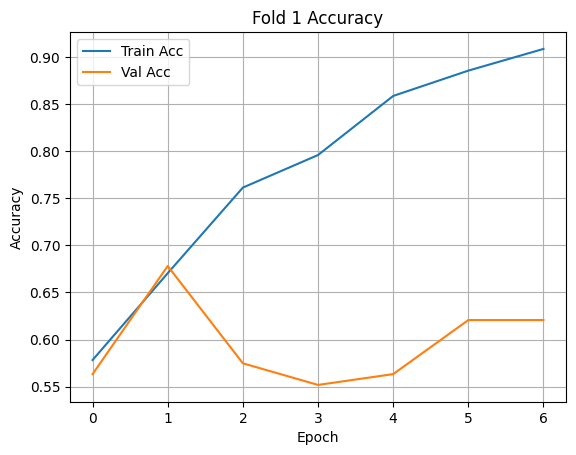

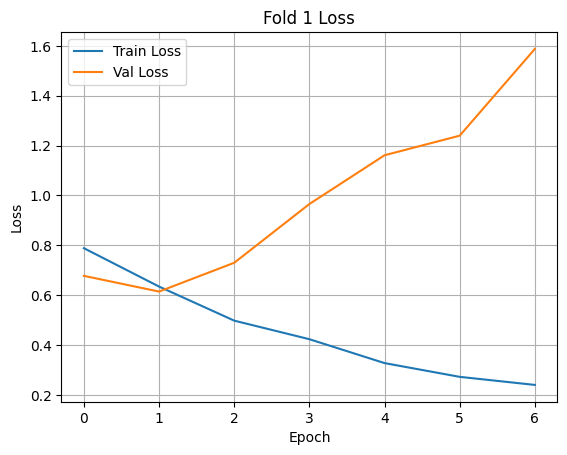

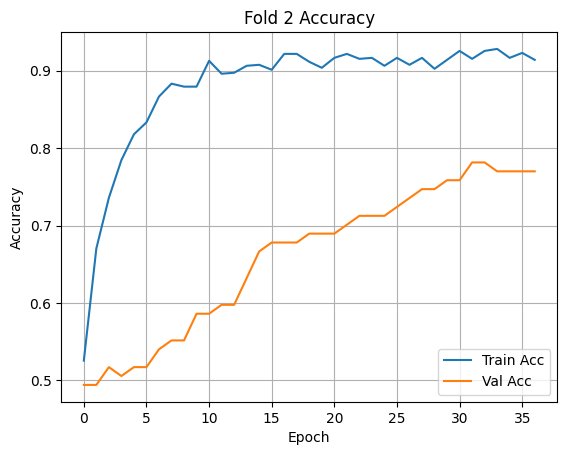

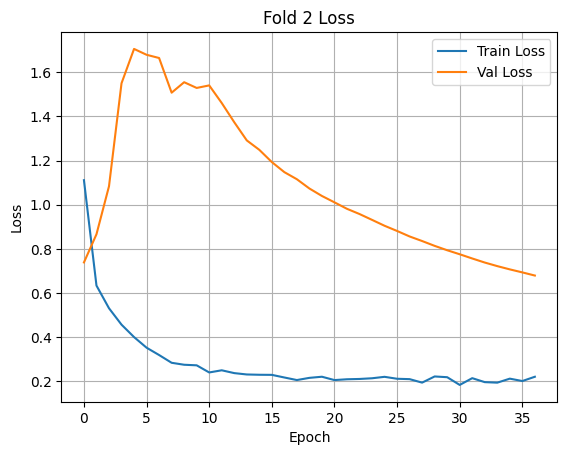

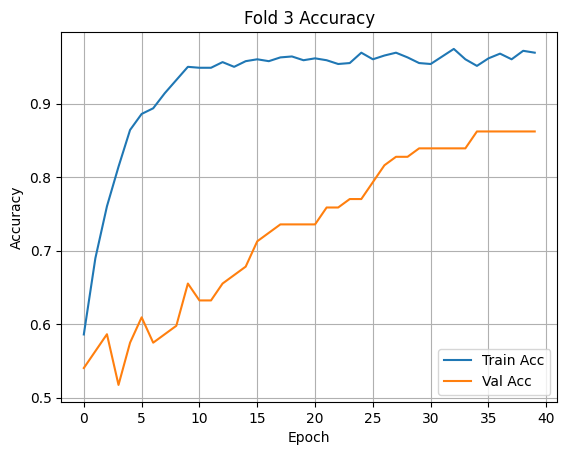

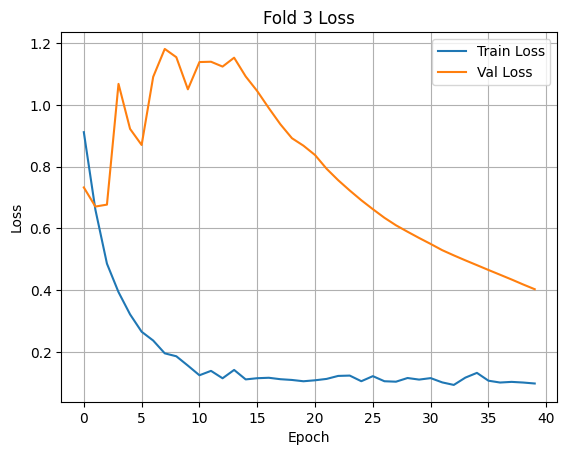

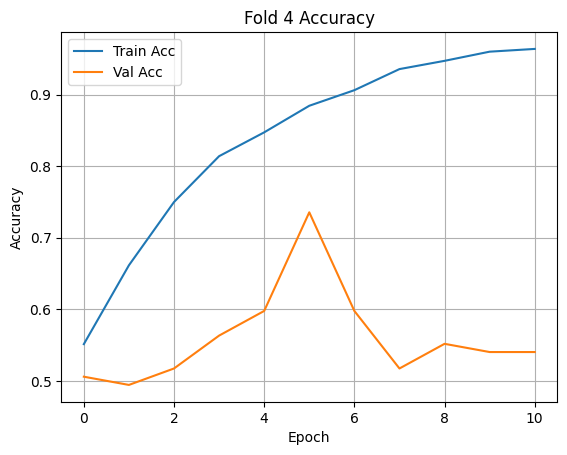

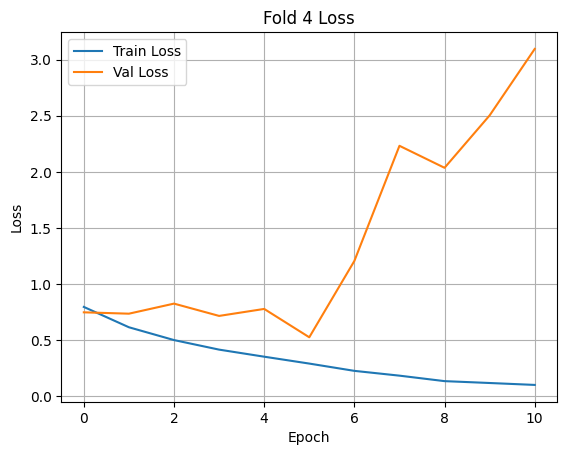

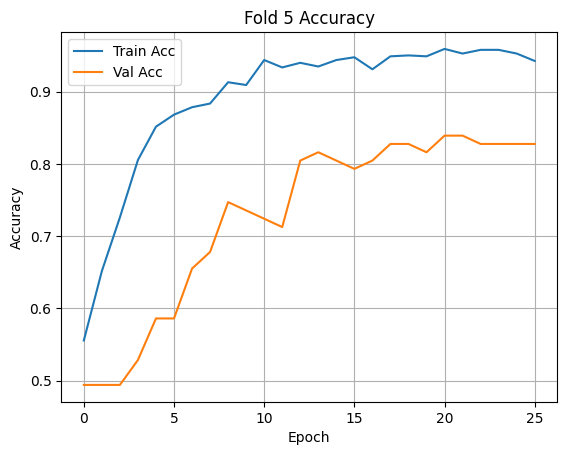

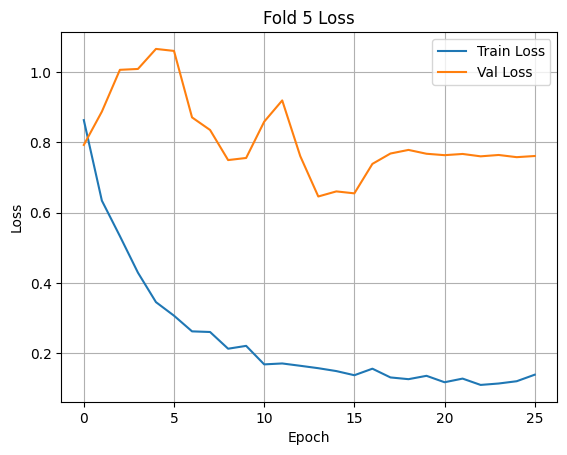

In [10]:
for i, hist in enumerate(all_histories, 1):
    plt.figure()
    plt.plot(hist['accuracy'], label='Train Acc')
    plt.plot(hist['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [11]:
# Save mô hình fold cuối cùng
model.save("mobilenetv2_hmm_faceplus_final.h5")


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.888338
precision    0.941162
recall       0.828525
f1           0.877464
auc          0.880423
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.972350,0.981132,0.962963,0.971963,0.764696
1,2,0.843318,0.862745,0.814815,0.838095,0.911740
2,3,0.811060,0.959459,0.651376,0.775956,0.928644
3,4,0.967742,0.990385,0.944954,0.967136,0.874023
4,5,0.847222,0.912088,0.768519,0.834171,0.923011


In [13]:
import pandas as pd

# Giả sử results đã có và bạn đã tạo results_df
results_df = pd.DataFrame(results)

# Tính các chỉ số
accuracy_mean = results_df['accuracy'].mean()
accuracy_std = results_df['accuracy'].std()  # dùng sample std (chia cho n-1)
accuracy_range = results_df['accuracy'].max() - results_df['accuracy'].min()
accuracy_cv_percent = (accuracy_std / accuracy_mean) * 100

# In kết quả
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))

print(f"\n✅ CV Accuracy (Mean Accuracy): {accuracy_mean:.4f}")
print(f"📈 Range Accuracy: {accuracy_range:.4f}")
print(f"📉 Accuracy CV% (std/mean): {accuracy_cv_percent:.2f}%")

# Hiển thị bảng kết quả nếu cần
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.888338
precision    0.941162
recall       0.828525
f1           0.877464
auc          0.880423
dtype: float64

✅ CV Accuracy (Mean Accuracy): 0.8883
📈 Range Accuracy: 0.1613
📉 Accuracy CV% (std/mean): 8.55%


,fold,accuracy,precision,recall,f1,auc
0,1,0.972350,0.981132,0.962963,0.971963,0.764696
1,2,0.843318,0.862745,0.814815,0.838095,0.911740
2,3,0.811060,0.959459,0.651376,0.775956,0.928644
3,4,0.967742,0.990385,0.944954,0.967136,0.874023
4,5,0.847222,0.912088,0.768519,0.834171,0.923011
